In [ ]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle

In [ ]:
def circular_orbit(t, K, P, phi, gamma):
    """
    Parameters
    ----------
    t: Array
        Input times (days)
    K: float
        Radial velocity semi-amplitude (m/s)
    P: float
        Orbital period (days)
    phi: float
        Orbital phase (radians)
    gamma: float
        Systemic velocity (m/s)

    Returns
    ----------
    Radial velocity (m/s) at input times
    """

    rv = K * np.sin((2 * np.pi * t) / P - phi) + gamma

    return rv

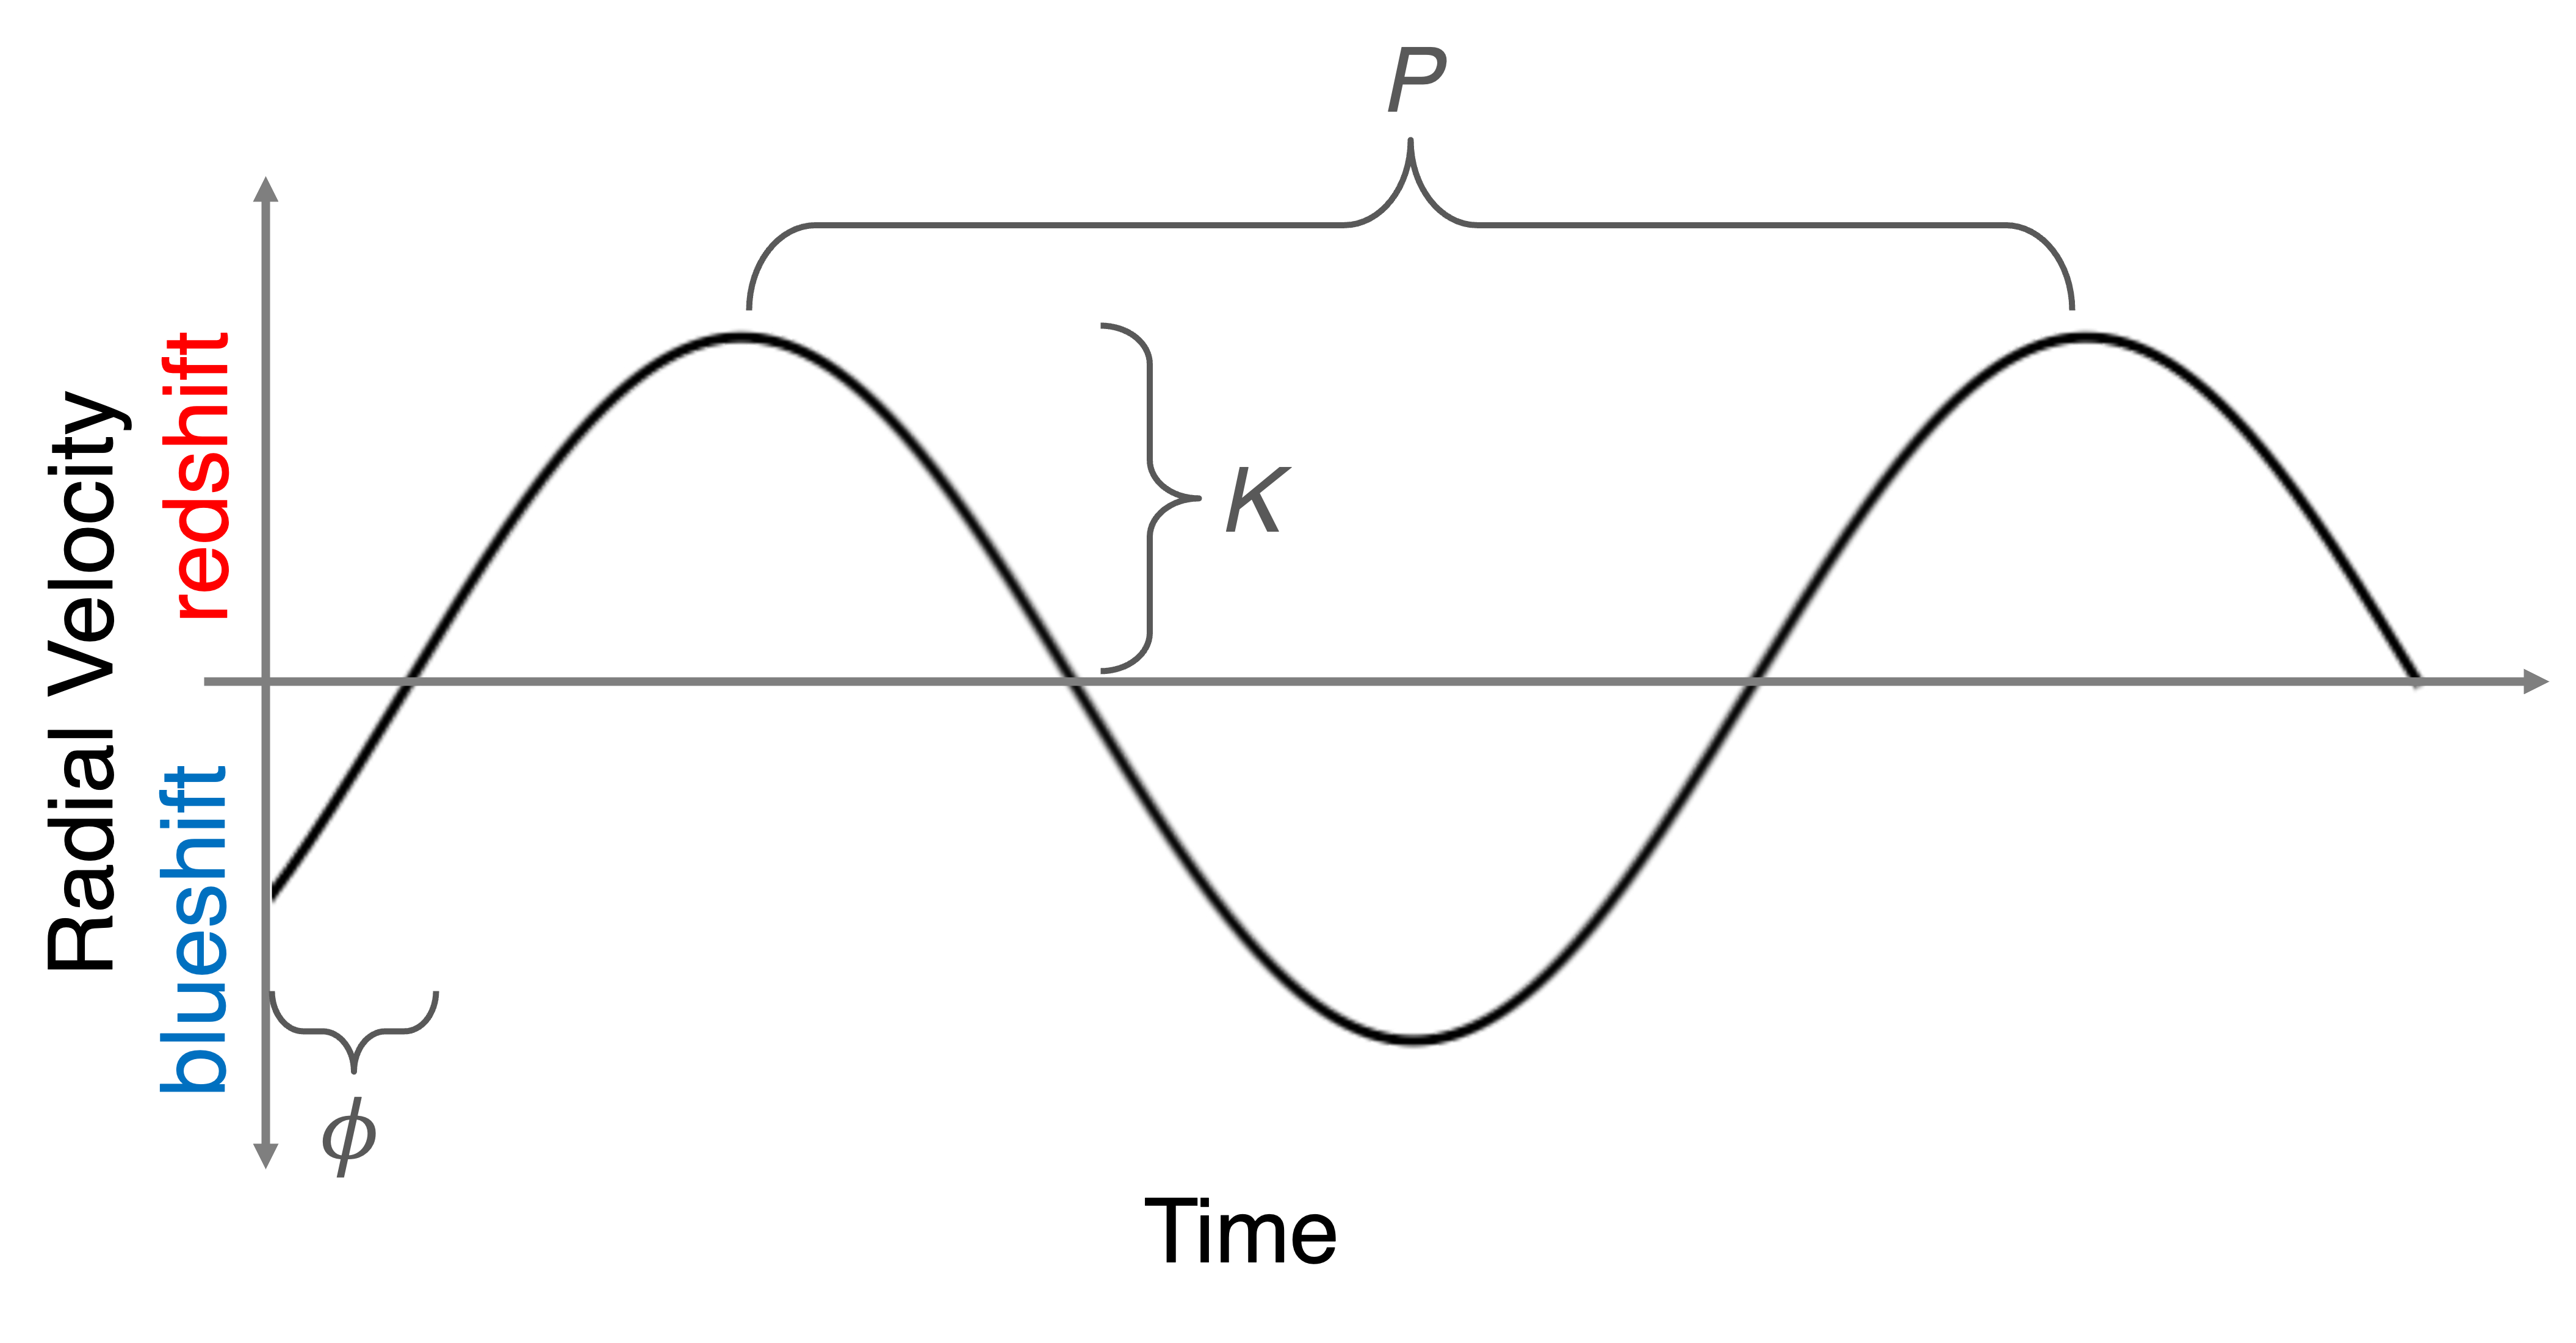

In this notebook, we're going to work with a more complicated model, one which can't easily be fit with a simple polynomial.

# Example 1: Fitting a circular orbit

Here, we will read in, plot, and fit pre-generated data that represents the radial velocity signatures of exoplanet orbits.
We will make the simplifying assumption that these orbits are circular, such that the radial velocity signal can be approximated with a sinusoid.

In [ ]:
data = pd.read_csv(os.path.join('SampleData','example1_rv_data.csv'))

t = data.t
rv = data.rv
rv_err = data.rv_err

In [ ]:
fig, ax = plt.subplots(figsize = (12,4))

ax.errorbar(t, rv, yerr=rv_err, color='k', marker='o', ls='')

ax.set_xlim(0,100)
ax.set_ylim(-35,-5)

ax.set_xlabel("Time [days]", fontsize=15)
ax.set_ylabel("Radial Velocity [m s$^{-1}$]", fontsize=15)

plt.show()

We will use the ```scipy.curve_fit()``` function to fit these data to our circular orbit model, which is defined above.

In [ ]:
fit_params, covariance = curve_fit(circular_orbit, t, rv, sigma=rv_err)

K_fit, P_fit, phi_fit, gamma_fit = fit_params
K_fit_err, P_fit_err, phi_fit_err, gamma_fit_err = np.sqrt(np.diag(covariance))

print("Best-fit parameters\n----------")
print("K = %.1f +/- %.1f" % (K_fit, K_fit_err))
print("P = %.1f +/- %.1f" % (P_fit, P_fit_err))
print("phi = %.1f +/- %.1f" % (phi_fit, phi_fit_err))
print("gamma = %.1f +/- %.1f" % (gamma_fit, gamma_fit_err))

Hmmmm, those numbers *might* be right. But we can't be certain. Let's plot the fit alongside the data to confirm.

In [ ]:
t_fit = np.linspace(0,100,10000)
rv_fit = circular_orbit(t_fit, K_fit, P_fit, phi_fit, gamma_fit)

fig, ax = plt.subplots(figsize = (12,4))

ax.errorbar(t, rv, yerr=rv_err, color='k', marker='o', ls='')
ax.plot(t_fit, rv_fit, color='C3')

ax.set_xlim(0,100)
ax.set_ylim(-35,-5)

ax.set_xlabel("Time [days]", fontsize=15)
ax.set_ylabel("Radial Velocity [m s$^{-1}$]", fontsize=15)

plt.show()

Ah - well that clearly didn't work!

Fitting functions like ```curve_fit()``` often fail to produce a good solution if they aren't initialized in the ballpark of the right answer. What I mean by this is that we should give ```curve_fit``` an estimate of what we think the model parameters might be. This can be accomplished by passing these guesses to the ```p0``` argument as follows:

In [ ]:
fit_params, covariance = curve_fit(circular_orbit, t, rv, sigma=rv_err, p0=[10.0, 20.0, -np.pi/2., -21.0])

K_fit, P_fit, phi_fit, gamma_fit = fit_params
K_fit_err, P_fit_err, phi_fit_err, gamma_fit_err = np.sqrt(np.diag(covariance))

print("Best-fit parameters\n----------")
print("K = %.1f +/- %.1f" % (K_fit, K_fit_err))
print("P = %.1f +/- %.1f" % (P_fit, P_fit_err))
print("phi = %.1f +/- %.1f" % (phi_fit, phi_fit_err))
print("gamma = %.1f +/- %.1f" % (gamma_fit, gamma_fit_err))

We can again plot the data and fit to double check. Here, we're also plotting the *residuals* to the fit, i.e., the remaining RV after we subtract off the best-fit planet signal. The residual is far smaller than the raw data, and it's just about consistent with the noise level.

In [ ]:
t_fit = np.linspace(0,100,10000)
rv_fit = circular_orbit(t_fit, K_fit, P_fit, phi_fit, gamma_fit)

residual = rv - circular_orbit(t, K_fit, P_fit, phi_fit, gamma_fit)

fig, (ax1, ax2) = plt.subplots(2,1,figsize = (12,6), gridspec_kw={'height_ratios':[3,1]})

ax1.errorbar(t, rv, yerr=rv_err, color='k', marker='o', ls='')
ax1.plot(t_fit, rv_fit, color='C3')

ax2.errorbar(t, residual, yerr=rv_err, color='k', marker='o', ls='')
ax2.axhline(y=0, color='C3')

ax1.set_ylim(-40,-5)
ax2.set_ylim(-7.5,7.5)

ax1.set_xlim(0,100)
ax2.set_xlim(0,100)

ax2.set_xlabel("Time [days]", fontsize=15)
ax1.set_ylabel("Radial Velocity [m s$^{-1}$]", fontsize=15)
ax2.set_ylabel("Residual [m s$^{-1}$]", fontsize=15)

plt.show()

# Example 2: Finding the orbital period

Our next example is another planet with a circular orbit. But you'll notice that the signal isn't as easy to pick out by eye. This is because the observing cadence isn't quite as dense -- we aren't taking data quite as frequently, so we don't see the sinusoidal pattern.

In [ ]:
data = pd.read_csv(os.path.join('SampleData','example2_rv_data.csv'))

t = data.t
rv = data.rv
rv_err = data.rv_err

In [ ]:
fig, ax = plt.subplots(figsize = (12,4))

ax.errorbar(t, rv, yerr=rv_err, color='k', marker='o', ls='')

ax.set_xlim(0,1000)
ax.set_ylim(15,75)
ax.set_xlabel("Time [days]", fontsize=15)
ax.set_ylabel("Radial Velocity [m s$^{-1}$]", fontsize=15)
plt.show()

To determine the period, we'll do a little bit of frequency analysis using a "Lomb-Scargle Periodogram".
This analysis allows us to identify the dominant periodic signals, such as the orbit of a planet, in data sets that are not densely sampled.

In [ ]:
period_array = np.logspace(-0.3,2,1000)
freq_array = 1./period_array

ls = LombScargle(t, rv)
power = ls.power(freq_array)

fig, ax = plt.subplots(figsize = (12,4))

ax.plot(period_array, power)

ax.set_xscale('log')
ax.set_ylim(0,1.2)
ax.set_xlim(5,100)

ax.set_xlabel('Period [days]', fontsize=15)
ax.set_ylabel('Normalized Power', fontsize=15)

plt.show()

In [ ]:
period_guess = period_array[np.argmax(power)]
print(period_guess)

"""
Estimate the values of K and gamma and fill them in below!
"""

K_guess = 
gamma_guess = 
phi_guess = 0.0

fit_params, covariance = curve_fit(circular_orbit, t, rv, sigma=rv_err, p0=[K_guess, period_guess, phi_guess, gamma_guess])

K_fit, P_fit, phi_fit, gamma_fit = fit_params
K_fit_err, P_fit_err, phi_fit_err, gamma_fit_err = np.sqrt(np.diag(covariance))

print("Best-fit parameters\n----------")
print("K = %.1f +/- %.1f" % (K_fit, K_fit_err))
print("P = %.1f +/- %.1f" % (P_fit, P_fit_err))
print("phi = %.1f +/- %.1f" % (phi_fit, phi_fit_err))
print("gamma = %.1f +/- %.1f" % (gamma_fit, gamma_fit_err))


In [ ]:
t_fit = np.linspace(0,1000,10000)
rv_fit = circular_orbit(t_fit, K_fit, P_fit, phi_fit, gamma_fit)

residual = rv - circular_orbit(t, K_fit, P_fit, phi_fit, gamma_fit)

fig, (ax1, ax2) = plt.subplots(2,1,figsize = (12,6), gridspec_kw={'height_ratios':[3,1]})

ax1.errorbar(t, rv, yerr=rv_err, color='k', marker='o', ls='')
ax1.plot(t_fit, rv_fit, color='C3')

ax2.errorbar(t, residual, yerr=rv_err, color='k', marker='o', ls='')
ax2.axhline(y=0, color='C3')

ax1.set_ylim(15,75)
ax2.set_ylim(-15,15)

ax1.set_xlim(0,1000)
ax2.set_xlim(0,1000)

ax.set_xlabel("Time [days]", fontsize=15)
ax.set_ylabel("Radial Velocity [m s$^{-1}$]", fontsize=15)


plt.show()

And finally, we can "phase-fold" the data to further confirm that this is the correct period.

In [ ]:
t_fold = (t - phi_fit*P_fit/(2*np.pi)) % P_fit - 0.5 * P_fit


fig, ax = plt.subplots(figsize = (6,4))

ax.errorbar(t_fold, rv, yerr=rv_err, color='k', marker='o', ls='')

ax.set_xlim(-0.5*P_fit,0.5*P_fit)
ax.set_ylim(15,75)

ax.set_xlabel("Orbital Phase [days]", fontsize=15)
ax.set_ylabel("Radial Velocity [m s$^{-1}$]", fontsize=15)

plt.show()

# Example 3: Your turn!

For our final example, we'll analyze and fit some *real* radial velocity data from an exoplanet that was recently discovered with NEID!

In [ ]:
data = pd.read_csv(os.path.join('SampleData','example3_rv_data.csv'))

t = data.t
rv = data.rv
rv_err = data.rv_err

In [ ]:
fig, ax = plt.subplots(figsize = (12,4))

ax.errorbar(t, rv, yerr=rv_err, color='k', marker='o', ls='')

ax.set_xlabel("Time [days]", fontsize=15)
ax.set_ylabel("Radial Velocity [m s$^{-1}$]", fontsize=15)

ax.set_xlim(0,1250)
ax.set_ylim(6,20)

plt.show()

In [ ]:
"""
Fill in the missing code to compute and plot the Lomb-Scargle periodogram of the NEID RV data.
"""

period_array = np.logspace(-0.3,2,1000)
freq_array = 1./period_array

power = 

fig, ax = plt.subplots(figsize = (12,4))

ax.plot(period_array, power)

ax.set_xscale('log')
ax.set_ylim(0,1.2)
ax.set_xlim(5,100)

ax.set_xlabel('Period [days]', fontsize=15)
ax.set_ylabel('Normalized Power', fontsize=15)

plt.show()

In [ ]:
"""
Use scipy.curve_fit() to compute the best-fit parameters.
Make use of the 'p0' argument to initialize the fit with a good guess for each parameter.
"""

fit_params, covariance = 


K_fit, P_fit, phi_fit, gamma_fit = fit_params
K_fit_err, P_fit_err, phi_fit_err, gamma_fit_err = np.sqrt(np.diag(covariance))

print("Best-fit parameters\n----------")
print("K = %.1f +/- %.1f" % (K_fit, K_fit_err))
print("P = %.1f +/- %.1f" % (P_fit, P_fit_err))
print("phi = %.1f +/- %.1f" % (phi_fit, phi_fit_err))
print("gamma = %.1f +/- %.1f" % (gamma_fit, gamma_fit_err))

In [ ]:
"""
Plot your fit and the residuals. Does it look right? 
"""
t_fit = np.linspace(0,1250,10000)
rv_fit = circular_orbit(t_fit, K_fit, P_fit, phi_fit, gamma_fit)

residual = rv - circular_orbit(t, K_fit, P_fit, phi_fit, gamma_fit)

fig, (ax1, ax2) = plt.subplots(2,1,figsize = (12,6), gridspec_kw={'height_ratios':[3,1]})

ax1.errorbar(t, rv, yerr=rv_err, color='k', marker='o', ls='')
ax1.plot(t_fit, rv_fit, color='C3')

ax2.errorbar(t, residual, yerr=rv_err, color='k', marker='o', ls='')
ax2.axhline(y=0, color='C3')

ax1.set_ylim(6,20)
ax2.set_ylim(-2.5,2.5)

ax1.set_xlim(0,1250)
ax2.set_xlim(0,1250)

ax2.set_xlabel("Time [days]", fontsize=15)
ax1.set_ylabel("Radial Velocity [m s$^{-1}$]", fontsize=15)
ax2.set_ylabel("Residual [m s$^{-1}$]", fontsize=15)

plt.show()

# HD 86728 b in context with the exoplanet population

In [ ]:
import exoplanet_utils

In [ ]:
mp_fit = exoplanet_utils.mass_from_K(K_fit, P_fit, mstar = 0.97)
print(mp_fit)

In [ ]:
periods, masses = exoplanet_utils.get_exoplanet_demographics(method='Radial Velocity')

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(periods, masses, marker='.', ls='')

ax.plot(P_fit, mp_fit, marker='o', mec='k', mfc='r', ms=12, mew=3)

ax.text(365,1,r'$\oplus$', color='green', fontsize=25)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(0.5,5e4)
ax.set_ylim(0.1,1e4)

ax.set_xlabel('Orbital Period [d]', fontsize=15)
ax.set_ylabel('Planet Mass [Earth masses]', fontsize=15)